A very simple 3-layer Fully connected network is defined to illustrate how Batch normalization works. The 1st and 2nd FC layer have 100 activations and the last FC (readout) has 10 activations for each training example. 

In [1]:
# Setup
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from autodiff import *

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

iterations = 40000
eval_every_steps = 50
batch = 50

w1 = np.random.normal(size=(784, 100)).astype(np.float32)
w2 = np.random.normal(size=(100, 100)).astype(np.float32)
w3 = np.random.normal(size=(100, 10)).astype(np.float32)

ones100 = np.ones((1, 100))
zeros100 = np.zeros((1, 100))
zeros10 = np.zeros((10,))

epsilon = 1e-3

sess = Session()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Define the network with and without batch normalization. Evaluate the two networks every 50 iterations. Record the pre-nonlinearity activations of the 2nd FC layer in `A` and `B`.

In [2]:
def build_graph(batch_size, sess):
    X = PlaceholderOp((batch_size, 784), False, sess)
    Y = PlaceholderOp((batch_size, 10), False, sess)

    W1 = PlaceholderOp((784, 100), sess=sess)
    B1 = PlaceholderOp((100,), sess=sess)
    W2 = PlaceholderOp((100, 100), sess=sess)
    B2 = PlaceholderOp((100,), sess=sess)
    W3 = PlaceholderOp((100, 10), sess=sess)
    B3 = PlaceholderOp((10,), sess=sess)

    Z1 = BiasAddOp(MatMulOp(X, W1, sess), B1, sess)
    L1 = SigmoidOp(Z1, sess)
    Z2 = BiasAddOp(MatMulOp(L1, W2, sess), B2, sess)
    L2 = SigmoidOp(Z2, sess)

    LOGITS = BiasAddOp(MatMulOp(L2, W3, sess), B3, sess)
    CROSS_ENTROPY = SoftmaxCrossEntropyWithLogitsOp(Y, LOGITS, sess)

    W1_BN = PlaceholderOp((784, 100), sess=sess)
    BETA1_BN = PlaceholderOp((1, 100), sess=sess)
    SCALE1_BN = PlaceholderOp((1, 100), sess=sess)
    W2_BN = PlaceholderOp((100, 100), sess=sess)
    BETA2_BN = PlaceholderOp((1, 100), sess=sess)
    SCALE2_BN = PlaceholderOp((1, 100), sess=sess)
    W3_BN = PlaceholderOp((100, 10), sess=sess)
    B3_BN = PlaceholderOp((10,), sess=sess)

    Z1_BN = MatMulOp(X, W1_BN, sess)
    Z1_BN_MV = MomentsOp(Z1_BN, [0], sess)
    BN1 = BatchNormOp(Z1_BN, Z1_BN_MV, BETA1_BN, SCALE1_BN, epsilon, sess)
    L1_BN = SigmoidOp(BN1, sess)
    Z2_BN = MatMulOp(L1_BN, W2_BN, sess)
    Z2_BN_MV = MomentsOp(Z2_BN, [0], sess)
    BN2 = BatchNormOp(Z2_BN, Z2_BN_MV, BETA2_BN, SCALE2_BN, epsilon, sess)
    L2_BN = SigmoidOp(BN2, sess)

    LOGITS_BN = BiasAddOp(MatMulOp(L2_BN, W3_BN, sess), B3_BN, sess)
    CROSS_ENTROPY_BN = SoftmaxCrossEntropyWithLogitsOp(Y, LOGITS_BN, sess)

    PARAMS = [W1, B1, W2, B2, W3, B3, W1_BN, BETA1_BN, SCALE1_BN, W2_BN, BETA2_BN, SCALE2_BN, W3_BN, B3_BN]

    return X, Y, LOGITS, CROSS_ENTROPY, LOGITS_BN, CROSS_ENTROPY_BN, PARAMS, Z2, BN2


X, Y, _, CROSS_ENTROPY, _, CROSS_ENTROPY_BN, PARAMS, _, _ = build_graph(batch, sess)
initial_values = [w1, np.zeros(100), w2, np.zeros(100), w3, np.zeros(10), 
                  w1, zeros100, ones100, w2, zeros100, ones100, w3, zeros10]
feed_dict = dict(zip(PARAMS, initial_values))
    
X_batch, _, LOGITS_batch, _, LOGITS_BN_batch, _, PARAMS_batch, Z2_batch, BN2_batch = build_graph(10000, sess)

params = {"alpha": 0.01}
accuracy, accuracy_bn, A, B = [], [], [], []

y_true_test = mnist.test.labels.argmax(axis=1)

for i in np.arange(iterations):
    feed_dict[X], feed_dict[Y] = mnist.train.next_batch(batch)
    tensor_values = [feed_dict[tensor] for tensor in PARAMS]

    if i % eval_every_steps == 0:
        feed_dict_batch = dict(zip(PARAMS_batch, tensor_values))
        feed_dict_batch[X_batch] = mnist.test.images

        LOGITS_batch_val = LOGITS_batch.eval(feed_dict_batch)
        LOGITS_BN_batch_val = LOGITS_BN_batch.eval(feed_dict_batch)

        accuracy.append(np.mean(y_true_test == LOGITS_batch_val.argmax(axis=1)))
        accuracy_bn.append(np.mean(y_true_test == LOGITS_BN_batch_val.argmax(axis=1)))
        A.append(Z2_batch.eval(feed_dict_batch).mean(axis=0))
        B.append(BN2_batch.eval(feed_dict_batch).mean(axis=0))

    sess.sgd_update(params, CROSS_ENTROPY, feed_dict)
    sess.sgd_update(params, CROSS_ENTROPY_BN, feed_dict)

    if i % 2000 == 0:
        print i

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000


Plot the accuracy of the two networks (w/ and w/o BN) on the test set as training progresses.

(0.8, 1)

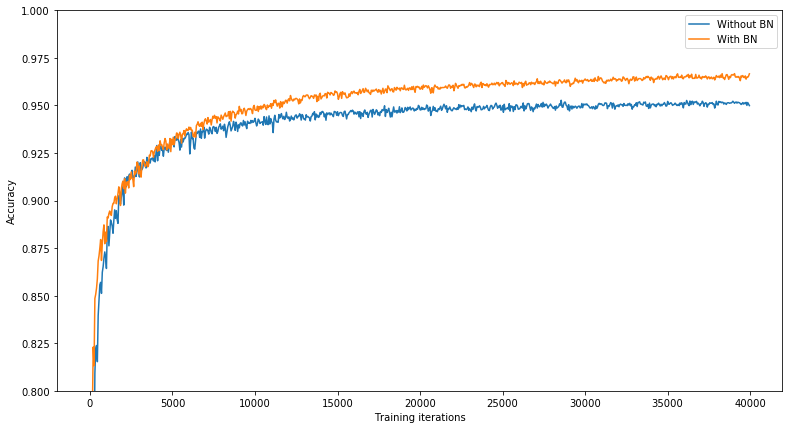

In [3]:
import matplotlib
accuracy, accuracy_bn, A, B = np.array(accuracy), np.array(accuracy_bn), np.array(A), np.array(B)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(13, 7)

plt.plot(np.arange(0, iterations, eval_every_steps), accuracy)
plt.plot(np.arange(0, iterations, eval_every_steps), accuracy_bn)
plt.legend(["Without BN", "With BN"])
plt.xlabel("Training iterations")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1])

Plot the first 10 (out of 100) pre-nonlinearity activations in the 2nd layer of the networks w/ and w/o BN

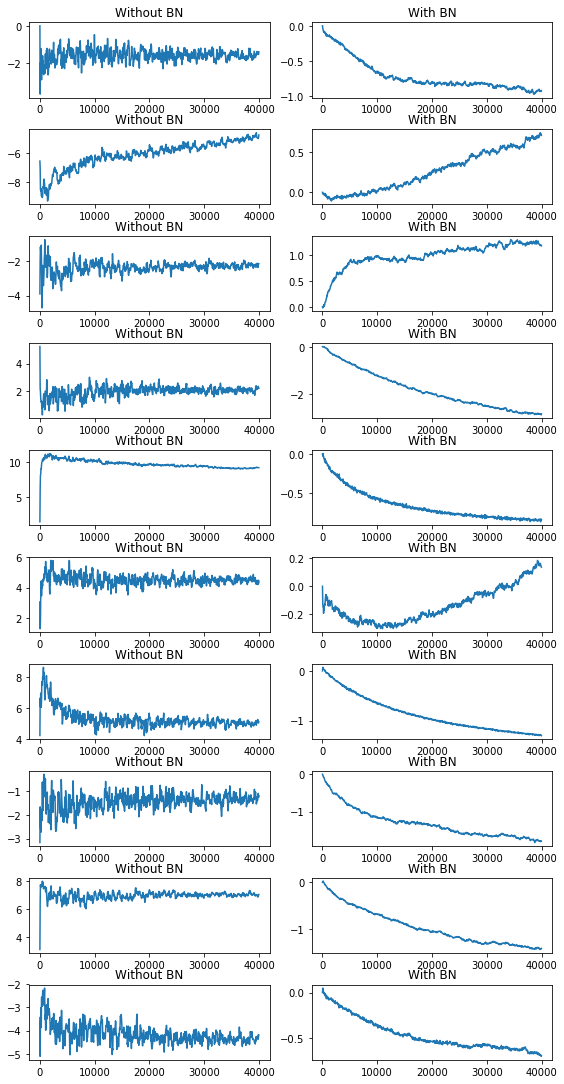

In [4]:
fig, axes = plt.subplots(10, 2, figsize=(8, 15))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(np.arange(0, iterations, eval_every_steps), A[:, i])
    ax[1].plot(np.arange(0, iterations, eval_every_steps), B[:, i])

Clearly the pre-nonlinearity activations in the network w/ BN exhibit much less fluctuations as training progresses.

More importantly, we see that the magnitude (see y-axis) of the pre-nonlinearity activations in the batch normalized network are much smaller than that in the network w/o BN (but not fixed on 0.0), which may have helped prevent the Sigmoid from being saturated, while still enables the network to represent nonlinear functions.